# **Lab 6: Convolutional Network Architectures - Brain Tumor MRI Images**

- Reece Iriye: 48255107
- Eileen Garcia: 48241821
- Trevor Dohm: 48376059

## **0: Imports**

In [1]:
# Import Statements

# MacOS Environment
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Data Manipulation
import numpy as np
import pandas as pd
import glob
import os

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Image Manipulation
from PIL import Image, ImageEnhance
import cv2

# Machine Learning
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, Reshape
from keras.models import Sequential, load_model
from keras.preprocessing.image import ImageDataGenerator

# Warnings
from typing import List, Dict, Tuple
import warnings
warnings.filterwarnings('ignore')

In [2]:
print('Tensorflow Version:', tf.__version__)
tf.config.list_physical_devices('GPU')

Tensorflow Version: 2.10.0


[]

## **1: Business Understanding & Preprocessing**

### **1.1: Dataset Overview**

The "Brain Tumor MRI Dataset" on <a href="https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset">Kaggle</a> provides a comprehensive collection of human brain MRI images aimed at supporting the accurate detection and classification of brain tumors. Consisting of 7,023 images from three distinct datasets - figshare, SARTAJ, and Br35H - this dataset separates MRI scans of brains into four categories: `glioma`, `meningioma`, `no tumor`, and `pituitary`. The dataset has seen several changes according to the description on Kaggle, with some `glioma` images from the SARTAJ dataset being replaced due to inaccuracies, highlighting ongoing modifications being made to the dataset for improved reliability and data quality. With images from the Br35H dataset constituting the `no tumor` class, users should be mindful that the images in this dataset come in varied sizes, meaning that pre-processing and re-sizing must be employed for us to achieve consistent analysis and improved model accuracy.

### **1.2: Prediction Task and Stakeholder Interest**

Brain tumors as a whole pose severe risks given the confined space of the skull, whether or not they are <a href="https://www.cedars-sinai.org/blog/diagnosed-with-benign-tumor.html">malignant or benign</a>. Growth of these tumors can potentially lead to brain damage and life-threatening situations. Timely detection and precise classification of these tumors are absolutely essential in guiding pre-emptive medical diagnosis before tumors signifcantly effect and harm a patient. With MRI's being a predominant imaging technique in this realm, there is a pressing need for advanced diagnostic models that can detect, classify by type, and pinpoint tumor locations effectively. This dataset, assembled from various sources and continuously refined, aims to provide a rich resource for researchers and data scientists to develop advanced machine learning models to aid in these critical diagnostic tasks.

This MRI dataset from Kaggle has been created with the specific intention to facilitate the development of models capable of detecting the presence of a brain tumor from MRI scans and classifying them by type. Medical practitioners and technicians can then use them as an advisory tool to make more precise diagnoses, leading to more targeted treatment options. Accurate labels are extremely important. It's crucial to acknowledge potential inaccuracies, such as those noted in the SARTAJ dataset, ensuring that machine learning models are trained on the most reliable data available.

### **1.3: Data Preprocessing Steps**

#### **1.3.1: Image Dimensions Standardization**

The Kaggle brain MRI dataset is structured in distinct training and testing folders. We are going to merge all of these together into one dataset then perform our own data splitting in section **2**.

All MRI images are likely varying in size, with some images being much larger than others and some images potentially being stretched in ways that could not be interpreted in a standard way by a Convolutional Neural Network or a transformer. We will standardize image size by stretching and/or squeezing images to fit into a $256 \times 256$ pixel dimension. This is a crucial preprocessing step. Neural networks, especially convolutional ones, require a consistent input size. Resizing all images to a uniform shape ensures that the network receives inputs in a consistent format, allowing us to batch process the data. Furthermore, downsizing larger images can also speed up the training process, as smaller images generally require less computational resources. On the other hand, recognizable features can be rendered from larger MRI screens with high dimensions could maybe lost from compression, but we are preferring interpretability in this scenario.

Because the images are MRI scans, we will read in the data and ensure that the images are grayscaled. MRI scans represent variations in tissue properties, not colors as in everyday images. Hence, we read in the data ensuring the images are in grayscale. Grayscaling, in this context, isn't about removing color; instead, it's about representing the MRI scans in a format that aligns with their natural presentation. By using grayscale, we utilize a single channel of floating point values, as opposed to the three channels (RGB) found in colored images. This not only aligns with the nature of MRI scans but also reduces the memory requirement to represent these images by one-third, making processing more efficient.

We will normalize the floating point representation of each grayscaled pixel value by dividing pixel values by 255. This scales all pixel values between 0 and 1. Normalization is an important step in image processing for neural networks, because networks tend to converge faster with normalized inputs. By keeping pixel values within a small range, it ensures that no particular set of weights gets updated disproportionately during the backpropagation process when fine-tuning or training a neural network.

In [3]:
# Load Train / Test Data
train_data_mri: str = 'Dataset/Training/'
test_data_mri: str = 'Dataset/Testing/'
IMG_SIZE: int = 256

# Label Encoding
labels: List[str] = ['glioma', 'meningioma', 'notumor', 'pituitary']
label_indexes: Dict[str, int] = {
    label: i 
    for i, label in enumerate(labels)
}

# Empty Lists For Data
train_paths: List[np.ndarray] = []  # List of numpy arrays
train_labels: List[int] = []  # List of integers (encoded labels)
test_paths: List[np.ndarray] = []
test_labels: List[int] = []

# Load Training Data
for label in labels:
    for img_file in glob.glob(train_data_mri + f'/{label}/*.jpg'):
        img: np.ndarray = cv2.imread(img_file, 0)  # This loads in grayscale. Remove ',0' for color.
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize if necessary
        img = img.astype(np.float32) / 255.0  # Normalize pixel values
        train_paths.append(img)
        train_labels.append(label_indexes[label])

# Load Testing Data
for label in labels:
    for img_file in glob.glob(test_data_mri + f'/{label}/*.jpg'):
        img: np.ndarray = cv2.imread(img_file, 0)  # This loads in grayscale. Remove ',0' for color.
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize if necessary
        img = img.astype(np.float32) / 255.0  # Normalize pixel values
        test_paths.append(img)
        test_labels.append(label_indexes[label])  

# Converting Lists To Numpy Arrays
train_paths = np.array(train_paths)
train_labels: np.ndarray = np.array(train_labels)
test_paths: np.ndarray = np.array(test_paths)
test_labels: np.ndarray = np.array(test_labels)

Ideally, having more images to train on would be preferrable, but 5,712 MRI scans spanning across multiple data sources is strong nonetheless. Diving deeper, let's check the total appearances for each class in the training data. 

In [4]:
# Find indices for each label
train_indices_0: List[int] = np.where(np.array(train_labels) == 0)[0]
train_indices_1: List[int] = np.where(np.array(train_labels) == 1)[0]
train_indices_2: List[int] = np.where(np.array(train_labels) == 2)[0]
train_indices_3: List[int] = np.where(np.array(train_labels) == 3)[0]

# Total class distributions
print(f"Glioma training data MRI scans: {len(train_indices_0)}.")
print(f"Meningioma training data MRI scans: {len(train_indices_1)}.")
print(f"No Tumor training data MRI scans: {len(train_indices_2)}.")
print(f"Pituitary training data MRI scans: {len(train_indices_3)}.")
print("Total MRI scans with a tumor: {}.".format(
    len(train_indices_0) + len(train_indices_1) + len(train_indices_3)
))

Glioma training data MRI scans: 1321.
Meningioma training data MRI scans: 1339.
No Tumor training data MRI scans: 1595.
Pituitary training data MRI scans: 1457.
Total MRI scans with a tumor: 4117.


The MRI scans labeled as "no tumor" form a significant portion when compared to individual tumor classes. However, overall, the classes are relatively well-balanced. If our goal is to classify the specific type of tumor, this even distribution is advantageous, as it minimizes the risk of the model being overly biased towards a particular class.

On the other hand, if the objective shifts to merely detecting the presence or absence of a tumor, there's a potential pitfall. Out of the 5,712 images, 4,117 showcase some form of tumor. In such a scenario, a binary classification model might be more inclined to predict the presence of a tumor, given that it represents the majority of the dataset. This could lead to the model being overly optimistic about tumor existence. This is actually not terrible problem to have, as a model that overly predicts the existence of a tumor is much stronger than a model that does the opposite. The reason why is because the implications for a false positive for predicting the existence of a tumor is much less costly then a false negative where the model misses a tumor.

### **1.4: Visualizing Content in the Dataset**

#### **1.4.1: Displaying Some Images**

In the plot below, we display some images from the training folder provided by Kaggle. The first 10 images with a label 0 represent a glioma tumor, the next 10 images with a label 1 represent a meningioma tumor, then the 10 after that with the label 2 represent a lack of existence of a tumor, and the last 10 images with the label 3 represent pituitary tumors. 

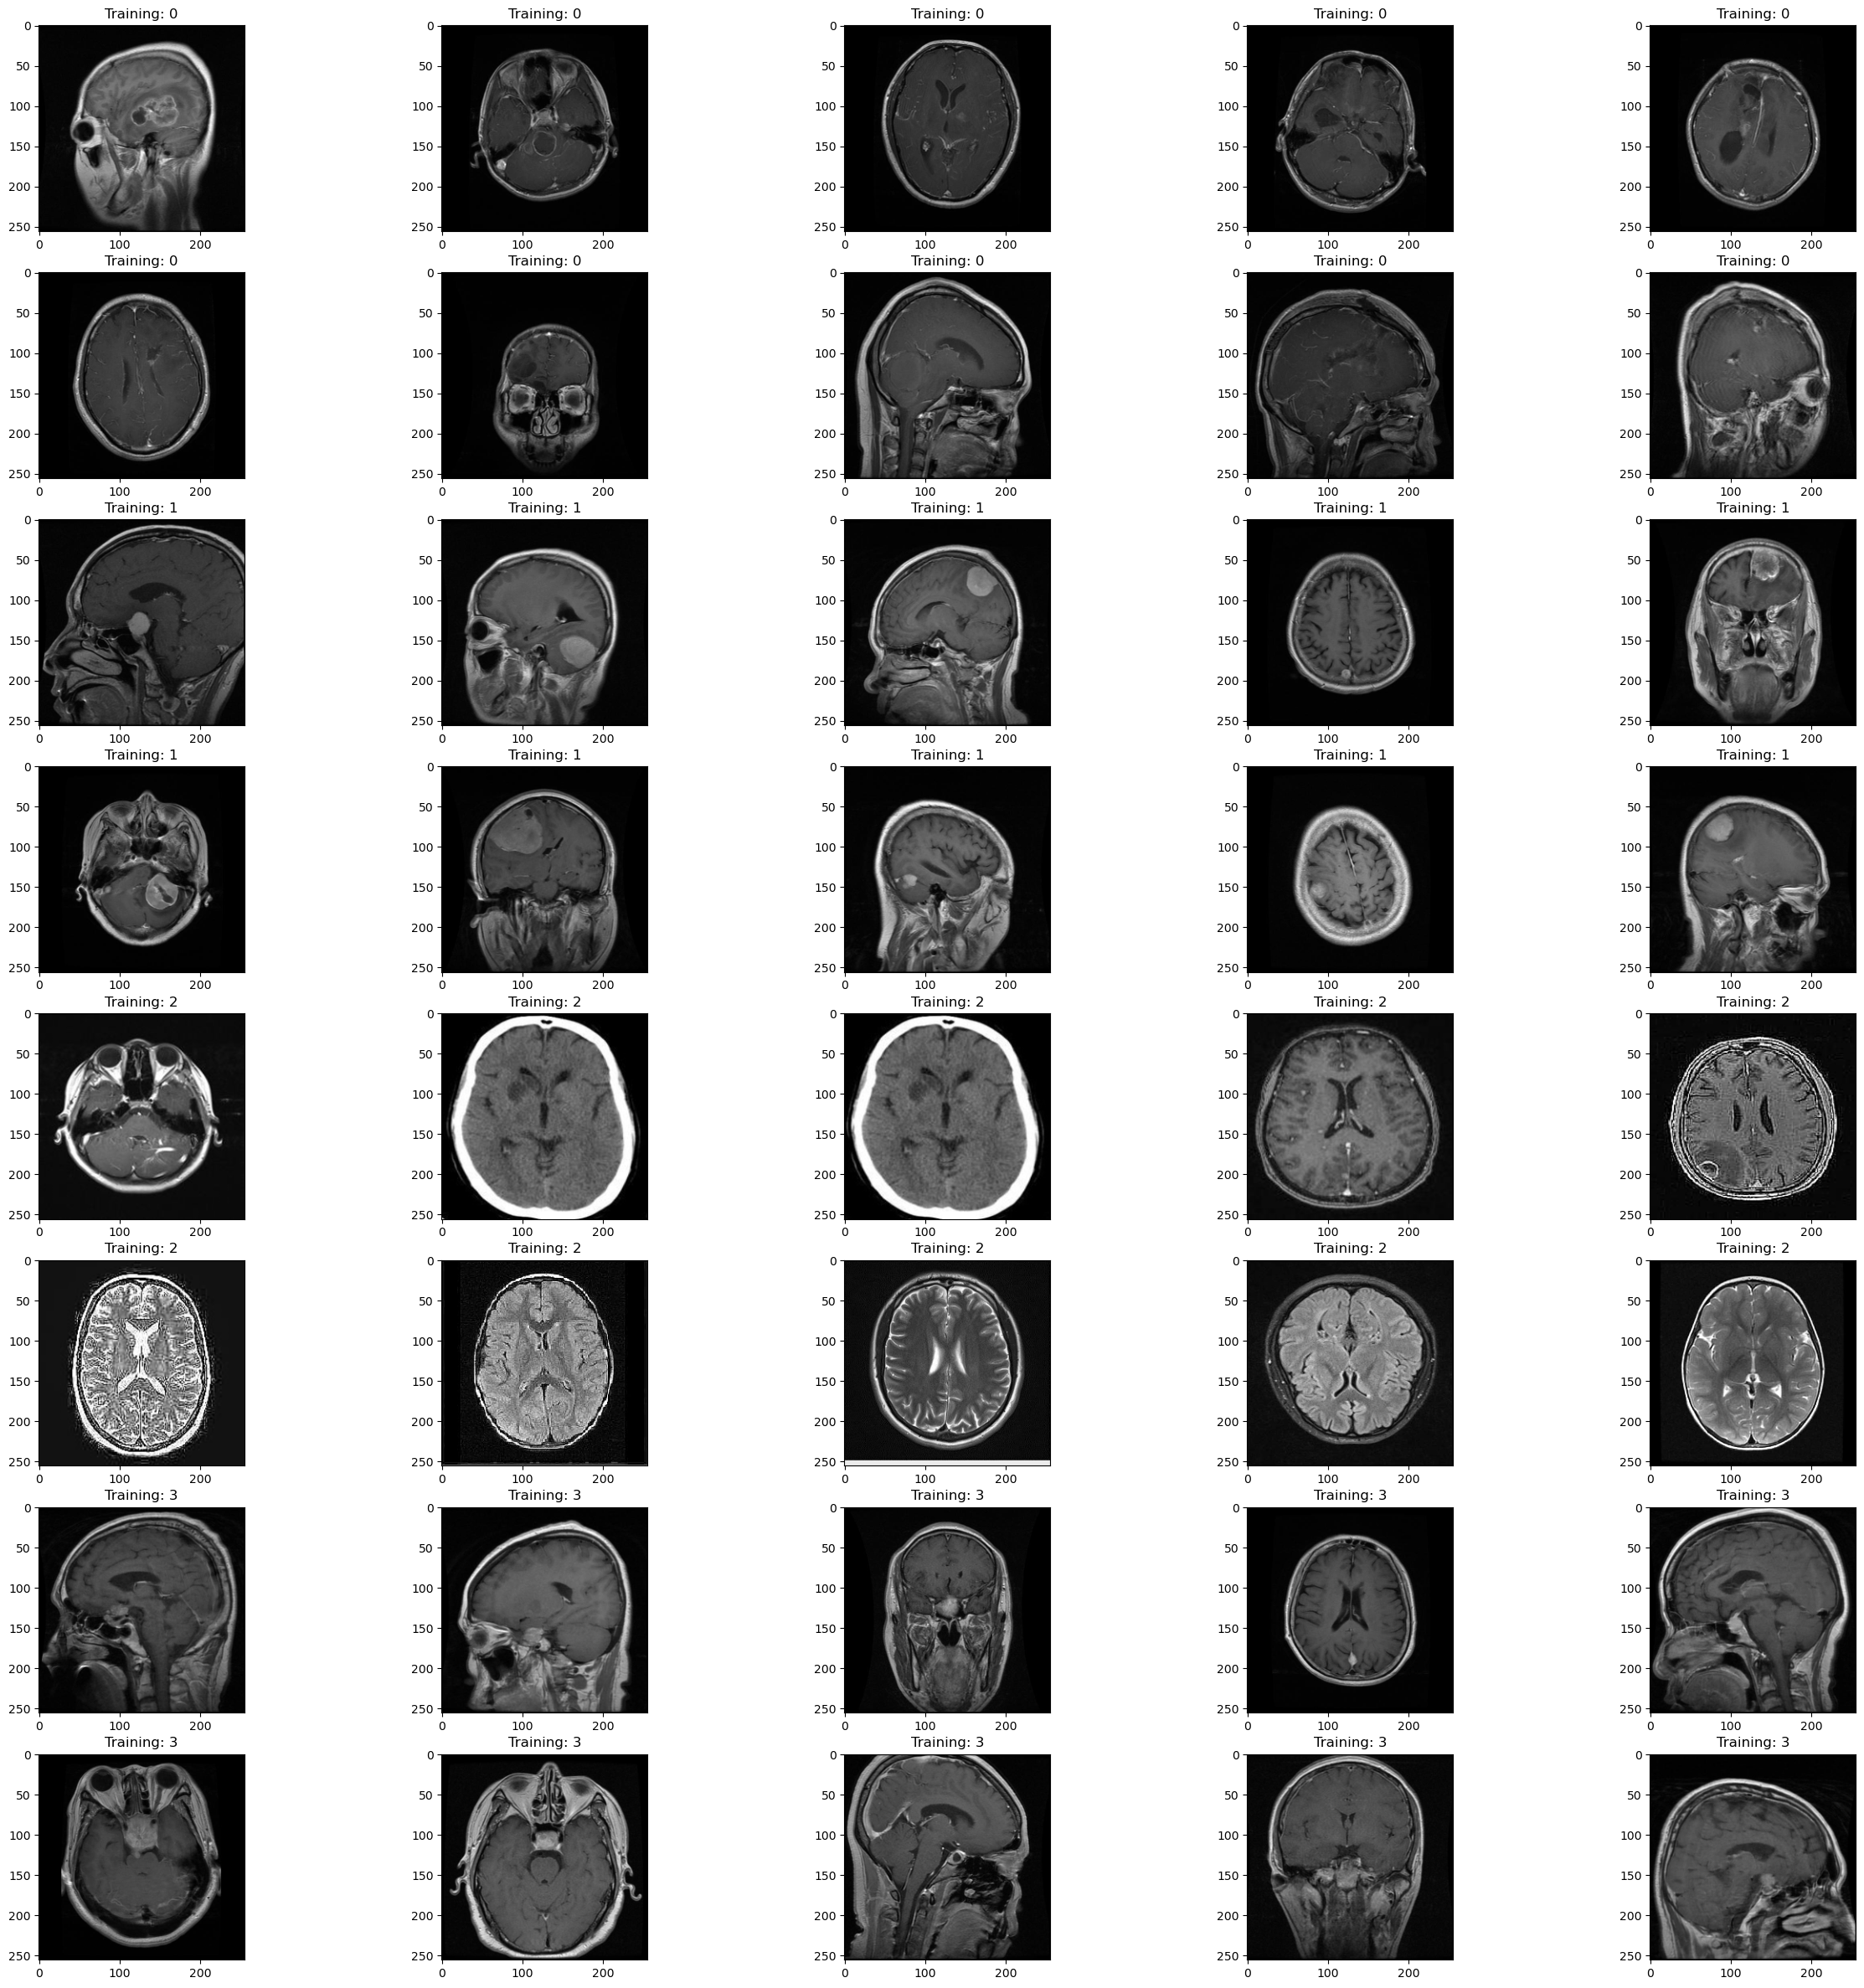

In [5]:
# Display some images from train_paths
plt.figure(figsize=(30, 30))

# Randomly select 10 indices from each set
train_random_indices_0: List[int] = np.random.choice(train_indices_0, 10, replace=False)
train_random_indices_1: List[int] = np.random.choice(train_indices_1, 10, replace=False)
train_random_indices_2: List[int] = np.random.choice(train_indices_2, 10, replace=False)
train_random_indices_3: List[int] = np.random.choice(train_indices_3, 10, replace=False)

train_plot_indices: List[int] = np.concatenate([
    train_random_indices_0, 
    train_random_indices_1, 
    train_random_indices_2, 
    train_random_indices_3,
])

# Ensure indices are unique and within bounds
train_plot_indices = list(set(train_plot_indices))
train_plot_indices.sort()

for index, (image, label) in enumerate(zip(train_paths[train_plot_indices], train_labels[train_plot_indices])):
    plt.subplot(8, 5, index + 1)
    plt.imshow(np.reshape(image, (IMG_SIZE, IMG_SIZE)), cmap=plt.cm.gray)
    plt.title(f'Training: {label}')
    
plt.show()

#### **1.4.2: Listing the Overall Class Distribution for all 4 Classes**

In [7]:
# Insert the total amount of images that appear in the dataset
TOTAL_IMAGES: int = (
    len(train_indices_0) + len(test_indices_0) + 
    len(train_indices_1) + len(test_indices_1) + 
    len(train_indices_2) + len(test_indices_2) + 
    len(train_indices_3) + len(test_indices_3) 
)

# Total number of each individual class
print(f"Number of Glioma images in dataset: {len(train_indices_0) + len(test_indices_0)}")
print(f"Number of Meningioma images in dataset: {len(train_indices_1) + len(test_indices_1)}")
print(f"Number of No Tumor images in dataset: {len(train_indices_2) + len(test_indices_2)}")
print(f"Number of Pituitary images in dataset: {len(train_indices_3) + len(test_indices_3)}\n")

# Total proportion of each individual class
print(f"Proportion of Glioma images in dataset: {100*(len(train_indices_0) + len(test_indices_0)) / TOTAL_IMAGES:.3f}%")
print(f"Proportion of Meningioma images in dataset: {100*(len(train_indices_1) + len(test_indices_1)) / TOTAL_IMAGES:.3f}%")
print(f"Proportion of No Tumor images in dataset: {100*(len(train_indices_2) + len(test_indices_2)) / TOTAL_IMAGES:.3f}%")
print(f"Proportion of Pituitary images in dataset: {100*(len(train_indices_3) + len(test_indices_3)) / TOTAL_IMAGES:.3f}%\n")

# Print total images
print(f"Total Images in Dataset: {TOTAL_IMAGES}", end="")

Number of Glioma images in dataset: 1621
Number of Meningioma images in dataset: 1645
Number of No Tumor images in dataset: 2000
Number of Pituitary images in dataset: 1757

Proportion of Glioma images in dataset: 23.081%
Proportion of Meningioma images in dataset: 23.423%
Proportion of No Tumor images in dataset: 28.478%
Proportion of Pituitary images in dataset: 25.018%

Total Images in Dataset: 7023

The information above showcases the distribution of classes in our overall dataset that we will use before splitting it into a training and testing set. The distribution of the classes is pretty proportional, with a slightly higher representation of 'No Tumor' images. Understanding distribution is important before splitting the data into training and testing sets, as it tells us how to approach the splitting process in order to maintain a representative sample in both sets.

The dataset shows a relatively balanced distribution among the different tumor types, each around 23-25%. This balance benefits us when training the model since it needs to learn how to identify and distinguish between these tumor types effectively. 

However, the 'No Tumor' category is slightly overrepresented when compared to other categories. It is not a severe imbalance, but it is still important to consider during data splitting and model training. The over-representation might reflect the real world scenario where many scans don't show tumors, which makes it a relevant aspect of the dataset. 

The above tells us that we may want to use stratified splitting to ensure that each set mirrors the distribution as closely as possible, so that the model generalizes well across all classes and performs reliably on unseen data. 

Additionally, given this distribution, metrics like precision, recall, and the F2 score (which emphasizes recall) may be important to understand how well the model performs with respect to each class considering the slight imbalance towards 'No Tumor' images. 

The dataset's class distribution provides a solid foundation for building a reliable and effective diagnostic tool. The slight over-representation of 'No Tumor' images reflects a realistic aspect of medical imaging and should be factored into both the training process and the evaluation strategy. 


## **2: Preparation for Modeling and Analysis**

### **2.1: Metrics used to evaluate algorithm's performance**
Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

Our primary goal is to be accurate and reliable in identifying brain tumors. In this case, metrics that emphasize the model's ability to correctly identify positive cases (brains with tumors) are crucial. 

Since we are performing multiclass classification in a medical context, the metrics Precision, Recall, F2 Score, and Area Under the ROC Curve (AUC-ROC) for each class can provide us with a detailed understanding of a model's performance across the various classes. We will also take a look at a confusion matrix for the model.

#### Supplementary Metrics: Accuracy, Precision, and Recall
Although not the main focus, accuracy, precision, and recall still offer valuable information. Accuracy gives a quick overview of overall performance, precision provides insight into the rate of false positives, and recall complements the F2 Score by highlighting the model's ability to detect actual positives.

Precision in multiclass settings is calculated separately for each class. It calculates the number of correctly-classified instances within all instances labled as that specific class. Precision is crucial when the cost of false positives is high. In this case, falsely identifying a no-tumor scan as a tumor (false positive) may lead to unnecessary stress and additional testing for the patient.

Recall in multiclass settings is calculated for each class independently. It measures a model's ability to correctly identify all instances of a particular class. Recall measures the number of correctly identified instances within the actual instances of a class. In medical scenarios such as this, it is important to seek high recall, as missing a true tumor case (false negative) has life-threatening consequences. 

These metrics provide a broader context to understand the model's performance, supporting the more focused insights gained from the F2 Score and Confusion Matrix.


#### F1/F2 Scores
The F1 Score provides a single metric that balances both the precision and recall values for each class. It is useful when we need a balance between precision and recall and when the class distribution is uneven, as in our dataset. 

The F2 score is a variation of the F1 score that gives more weight to recall than precision. In this tumor detection application, the cost of missing a true positive (an existing tumor) is much higher than the cost of a false positive (classifying a no tumor scan as a tumor scan). The F2 score is appropriate in this case because it quantifies the model's performance by penalizing missed tumors more than incorrect tumor identification. This aligns with the priority of minimizing missed tumor diagnoses and ensuring patient safety.

Together, these metrics provide practical relevance by prioritizing the recall metrics to ensure patient safety. In this medical context, missing a tumor has significant implications for the patient. It is essential for medical imaging applications to prioritize catching cases that imply life-threatening scenarios for patients.


#### Area Under the Reciever Operating Characteristic Curve (AUC-ROC) for each class
ROC curves can be extended for use in multiclass settings to measure the performance of a model in classifying each class against all others. The AUC-ROC is useful to understand how well a model distinguishes each tumor type from the others. 

AUC-ROC can be extended from binary to multiclass settings using the following approaches:

- One-vs-Rest (OvR) Approach: 
    The AUC-ROC is calculated for each class by treating that class as the positive class and all other classes combined as the negative class. Then the individual AUC-ROC values can be averaged (simple or weighted basted on class representation) to get an overall performance metric.

- One-vs-One (OvO) Approach: 
    The AUC-ROC is computed for every pair of classes. This is more computationally intensive as it requires computing the metric for each class pair.

The multiclass AUC-ROC metric provides a clear, single metric that summarizes the discrimination ability of the model. In this case, this represents insight into how well the model can differentiate between the various types of brain tumors as well as the brains with no tumors.


#### Confusion Matrix
The Confusion Matrix is essential for visualizing the model's performance and to understand not just accuracy but the types of errors being made. 

In particular, we will focus on analyzing the upper diagonal of the confusion matrix, enabling us to focus on the false negatives. The detailed focus allows us to target improvements in the model and ensure that it is sensitive to the presence of the tumors. 



### Summary
These metrics offer a comprehensive evaluation of the model's performance in a medical imaging context. The F2 Score's emphasis on recall is crucial for prioritizing patient safety by minimizing missed tumor detections. The Confusion Matrix provides a clear view of error types, especially false negatives, which is vital for clinical applications. The ROC curve aids in understanding the model's discriminatory power. Meanwhile, accuracy, precision, and recall serve as supplementary metrics providing a broader overview of performance. This approach ensures not just a statistically sound evaluation but also one that is aligned with the practical and ethical considerations of medical diagnostics.

### **2.2: Using Stratified Shuffle Split to Divide our Data into Training and Testing Datasets**
Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 

We will use Stratified Shuffle Split to divide our dataset into training and testing datasets. 

This method maintains the original proportion of each class in both the training and testing datasets. This is crucial in medical imaging datasets where class distribution may not be perfectly balanced or where each class's representation is important for accurate diagnosis. 

Additionally, using stratified shuffle split allows for repeated random sampling of the data to ensure comprehensive use of all available data. 

Stratified Shuffle Split also mimics real-world applications. In practice, a diagnostic model would be expected to perform well on any random set of patients. By creating different random splits, this method simulates this scenario and provides a realistic evaluation of how the model might perform in a clinical setting.

Finally, using stratified shuffle split also addresses overfitting concerns. With limited data, the risk of overfitting is higher. Stratified Shuffle Split mitigates this by using different subsets of data in each iteration, testing the model's generalization capability.

Stratified Shuffle Split offers a balanced approach to maximize the available data, ensures that the class distribution is maintained in each split, and provides a realistic way to evaluate the model's performance. 

In a medical context, models need to be robust, accurate, and generalizable to varied subsets of patient data. This method simulates the diversity of real-world medical scenarios and ensures that our model is not just statistically valid but also applicable in a clinical environment. 

In [8]:
# Concatenate the original train/test split into one dataset
combined_paths = np.concatenate((train_paths, test_paths), axis=0)
combined_labels = np.concatenate((train_labels, test_labels), axis=0)

# Perform Stratified Shuffle Split
from sklearn.model_selection import StratifiedShuffleSplit

skf = StratifiedShuffleSplit(n_splits = 10, random_state = 42)
for train_index, test_index in skf.split(combined_paths, combined_labels):
    X_train, X_test = combined_paths[train_index], combined_paths[test_index]
    y_train, y_test = combined_labels[train_index], combined_labels[test_index]

# Train and evaluate model using X_train, y_train, X_test, y_test


In [9]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(6320, 256, 256) (6320,) (703, 256, 256) (703,)


In [10]:
datagen = ImageDataGenerator(
    rotation_range=10,  # degrees
    zoom_range=0.1,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# Note: When using this with actual MRI data, make sure the augmentation is sensible for your specific case.

In [11]:

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)),
    Flatten(),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [12]:


mlp_model = Sequential([
    Flatten(input_shape=(256, 256, 1)),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

mlp_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
